# Simple interaction models and the Judgement of Princeton

In [1]:
import numpy as np, scipy as sp, pandas as pd, pymc3 as pm
from scipy import stats
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [2]:
wines = pd.read_csv('data/Wines2012.csv', sep = ';')
wines.head(10)

,judge,flight,wine,score,wine.amer,judge.amer
0,Jean-M Cardebat,white,A1,10.0,1,0
1,Jean-M Cardebat,white,B1,13.0,1,0
2,Jean-M Cardebat,white,C1,14.0,0,0
3,Jean-M Cardebat,white,D1,15.0,0,0
4,Jean-M Cardebat,white,E1,8.0,1,0
5,Jean-M Cardebat,white,F1,13.0,1,0
6,Jean-M Cardebat,white,G1,15.0,1,0
7,Jean-M Cardebat,white,H1,11.0,0,0
8,Jean-M Cardebat,white,I1,9.0,1,0
9,Jean-M Cardebat,white,J1,12.0,0,0


## Preprocessing

In [3]:
wines[['wine']] = OrdinalEncoder(dtype=np.int64).fit_transform(wines[['wine']])
wines[['judge']] = OrdinalEncoder(dtype=np.int64).fit_transform(wines[['judge']])
wines['flight'] = 1 - OrdinalEncoder(dtype=np.int64).fit_transform(wines[['flight']])
wines[['score']] = StandardScaler().fit_transform(wines[['score']])
wines

,judge,flight,wine,score,wine.amer,judge.amer
0,3,0,0,-1.581002,1,0
1,3,0,2,-0.451715,1,0
2,3,0,4,-0.075286,0,0
3,3,0,6,0.301143,0,0
4,3,0,8,-2.333860,1,0
...,...,...,...,...,...,...
175,1,1,11,-0.828144,1,1
176,1,1,13,0.301143,0,1
177,1,1,15,0.677572,1,1
178,1,1,17,-2.710289,1,1


## Model 1: simple effects of wine and judge

Let's start by examining the effects of the wine and the judge.

$$ \begin{align*}
    y_i &\sim \mathrm{Normal}(\mu_i, \sigma) \\
    \mu_i &\sim \alpha + \beta_{W[j]} + \beta_{J[k]} \\
    \beta_{W[j]} &\sim \mathrm{Normal}(0, 0.5) \\
    \beta_{J[k]} &\sim \mathrm{Normal}(0, 0.5) \\
    \alpha &\sim \mathrm{Normal}(0, 0.2) \\
    \sigma &\sim \mathrm{Exponential}(1) \end{align*} $$
    
The brackets on the parameters indicate indexing; so, we really have a vector of $\beta_W$s, and we select out the relevant one for

In [4]:
with pm.Model() as wj_model:
    # Priors for parameters
    aW = pm.Normal('aW', 0, 0.5, shape = 20)
    aJ = pm.Normal('aJ', 0, 0.5, shape = 9)
    alpha = pm.Normal('alpha', 0, 0.2)
    sigma = pm.Exponential('sigma', 1)
    
    # Model equation
    mu = alpha + aW[wines['wine'].values] + aJ[wines['judge'].values] # use .values here to avoid annoying theano warnings
    
    # Observation model
    score = pm.Normal('score', mu = mu, sigma = sigma, observed = wines['score'])
    
    # Sampling
    wj_trace = pm.sample(2000, target_accept = 0.95)
    wj_sumtab = pm.summary(wj_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha, aJ, aW]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:06<00:00, 830.66draws/s]


array([<AxesSubplot:title={'center':'94.0% Credible Interval'}>],
      dtype=object)

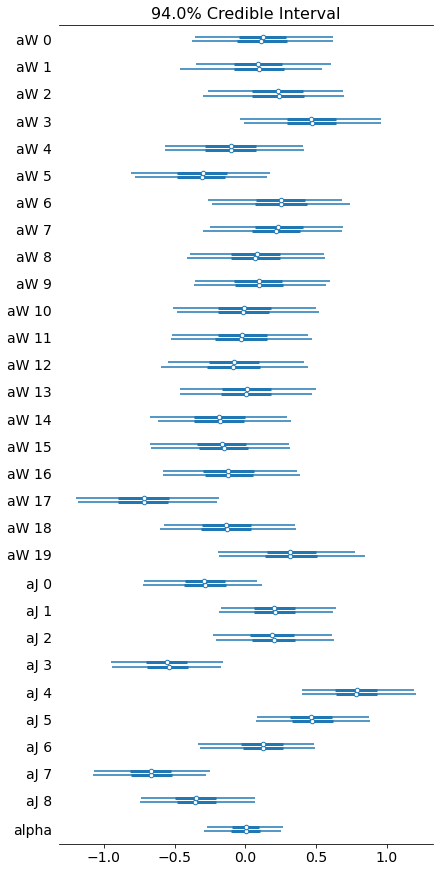

In [5]:
pm.forestplot(wj_trace, var_names = wj_trace.varnames.remove('sigma'))

There isn't a lot of variation between the wines; only one wine has its posterior interval completely away from 0, and a few more (e.g. wines 3, 5, 19) are close. There is more variation among judges, with several who consistently rate wines higher or lower than average. Judges rate by their own "internal scales", so this generally makes sense.

## Simple model: color/judge/region effects

There is a slight distinction between two approaches we can take to writing down the model. We can use indicator variables:

$$ \begin{align*} y_i &\sim \mathrm{Normal}(\mu_i, \sigma) \\
    \mu_i &\sim \alpha + \beta_{R} R + \beta_{J} J + \beta_{W} W \\
    \beta_{R} &\sim \mathrm{Normal}(0, 0.5) \\
    \beta_{J} &\sim \mathrm{Normal}(0, 0.5) \\
    \beta_{W} &\sim \mathrm{Normal}(0, 0.5) \\
    \alpha &\sim \mathrm{Normal}(0, 0.2) \\
    \sigma &\sim \mathrm{Exponential}(1) \end{align*} $$
where $R, J, W$ are indicators: 
* $R = 0$ if the wine is white, $R = 1$ if the wine is red
* $J = 0$ if the judge is French, $J = 1$ if the judge is American
* $W = 0$ if the wine is French, $W = 1$ if the wine is American

Another approach is to introduce a parameter for each value of the predictors, so that the intercepts are indexed by predictor values. This is the approach from the first model (individual wines) where we have a parameter for every wine and every judge.

$$ \begin{align*} y_i &\sim \mathrm{Normal}(\mu_i, \sigma) \\
    \mu_i &\sim \alpha + \beta_{R[k]} + \beta_{J[l]} + \beta_{W[m]} \\
    \beta_{R[k]} &\sim \mathrm{Normal}(0, 0.5) \\
    \beta_{J[l]} &\sim \mathrm{Normal}(0, 0.5) \\
    \beta_{W[m]} &\sim \mathrm{Normal}(0, 0.5) \\
    \alpha &\sim \mathrm{Normal}(0, 0.2) \\
    \sigma &\sim \mathrm{Exponential}(1) \end{align*} $$
    
The indicator variables drop out of the model equation, but now we have separate intercepts; e.g., $\beta_{R[0]}$ enters the equation when $R = 0$.

There may or may not be a difference in the results -- broadly, the index variable approach is a bit more flexible, as we will see below when we model interactions.

In [6]:
# Indicator variable version
with pm.Model() as indicator_model:
    # Priors
    bR = pm.Normal('bR', 0, 0.5)
    bJ = pm.Normal('bJ', 0, 0.5)
    bW = pm.Normal('bW', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', 0, 0.2)
    
    # Model equation
    mu = alpha + bR * wines['flight'] + bJ * wines['judge.amer'] + bW * wines['wine.amer']
    
    # Observation model
    score = pm.Normal('score', mu=mu, sigma=sigma, observed=wines['score'])
    
    # Sampling
    indicator_trace = pm.sample(1000, target_accept = 0.9)
    indicator_sumtab = pm.summary(indicator_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sigma, bW, bJ, bR]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:02<00:00, 1003.10draws/s]


In [7]:
# Index variable version
with pm.Model() as index_model:
    # Priors
    bR = pm.Normal('bR', 0, 0.5, shape = 2)
    bJ = pm.Normal('bJ', 0, 0.5, shape = 2)
    bW = pm.Normal('bW', 0, 0.5, shape = 2)
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', 0, 1)
    
    # Model equation 
    mu = alpha + bR[wines['flight'].values] + bJ[wines['judge.amer'].values] + bW[wines['wine.amer'].values]
    
    # Observation model
    score = pm.Normal('score', mu=mu, sigma=sigma, observed=wines['score'])
    
    # Sampling
    index_trace = pm.sample(1000, target_accept = 0.9)
    index_sumtab = pm.summary(index_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sigma, bW, bJ, bR]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:07<00:00, 417.09draws/s]


In [8]:
indicator_sumtab

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bR,-0.009,0.138,-0.270,0.255,0.003,0.003,1977.0,796.0,1975.0,1439.0,1.0
bJ,0.235,0.140,-0.026,0.488,0.003,0.003,1698.0,1468.0,1704.0,1421.0,1.0
bW,-0.180,0.138,-0.442,0.080,0.003,0.003,1655.0,1365.0,1655.0,1234.0,1.0
alpha,-0.017,0.124,-0.243,0.215,0.003,0.003,1436.0,1119.0,1436.0,1319.0,1.0
sigma,1.003,0.056,0.901,1.106,0.001,0.001,1411.0,1392.0,1449.0,1086.0,1.0


array([<AxesSubplot:title={'center':'94.0% Credible Interval'}>],
      dtype=object)

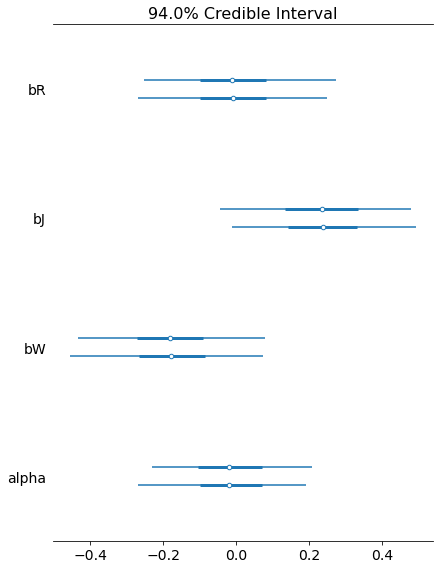

In [9]:
pm.forestplot(indicator_trace, var_names = ['bR', 'bJ', 'bW', 'alpha'])

The only really strong effect here (and it's borderline) is that American judges appear to rate wines a little higher. But this is probably dominated by judges 4 and 5, the two who consistently rate all wines a little higher (and are both American). Of the two judges who rate wines lower, one is American and one is French.

0.1792711023607228


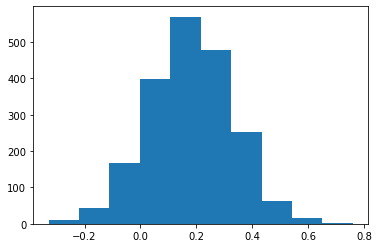

In [10]:
bW_diff = index_trace['bW'][:,0] - index_trace['bW'][:,1]
print(np.average(bW_diff))
plt.hist(bW_diff)
plt.show()

In [11]:
with pm.Model() as interaction:
    # Priors
    bR = pm.Normal('bR', 0, 0.5)
    bJ = pm.Normal('bJ', 0, 0.5)
    bW = pm.Normal('bW', 0, 0.5)
    bWJ = pm.Normal('bWJ', 0, 0.25)
    bJR = pm.Normal('bJR', 0, 0.25)
    bWR = pm.Normal('bWR', 0, 0.25)
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', 0, 0.2)
    
    # Model equation
    mu = alpha + bR * wines['flight'] + bJ * wines['judge.amer'] + bW * wines['wine.amer'] + \
        bWJ * wines['judge.amer'] * wines['wine.amer'] + bJR * wines['judge.amer'] * wines['flight'] + \
        bWR * wines['flight'] * wines['wine.amer']
    
    # Observation model
    score = pm.Normal('score', mu=mu, sigma=sigma, observed=wines['score'])
    
    # Sampling
    int_trace = pm.sample(1000, target_accept = 0.9)
    int_sumtab = pm.summary(int_trace, var_names = ['alpha', 'bR', 'bJ', 'bW', 'bWJ', 'bJR', 'bWR'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sigma, bWR, bJR, bWJ, bW, bJ, bR]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:04<00:00, 727.54draws/s]


In [12]:
int_sumtab

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.044,0.138,-0.303,0.219,0.004,0.003,1394.0,979.0,1395.0,1268.0,1.0
bR,0.087,0.187,-0.288,0.423,0.005,0.004,1603.0,1120.0,1601.0,1402.0,1.0
bJ,0.205,0.181,-0.133,0.540,0.005,0.004,1501.0,1337.0,1505.0,1350.0,1.0
bW,-0.082,0.181,-0.435,0.246,0.005,0.004,1397.0,1011.0,1398.0,1241.0,1.0
bWJ,-0.017,0.187,-0.355,0.330,0.005,0.004,1502.0,1084.0,1507.0,1314.0,1.0
bJR,0.047,0.178,-0.304,0.354,0.004,0.004,1690.0,1126.0,1693.0,1542.0,1.0
bWR,-0.220,0.183,-0.567,0.135,0.005,0.003,1466.0,1466.0,1506.0,1013.0,1.0


array([<AxesSubplot:title={'center':'94.0% Credible Interval'}>],
      dtype=object)

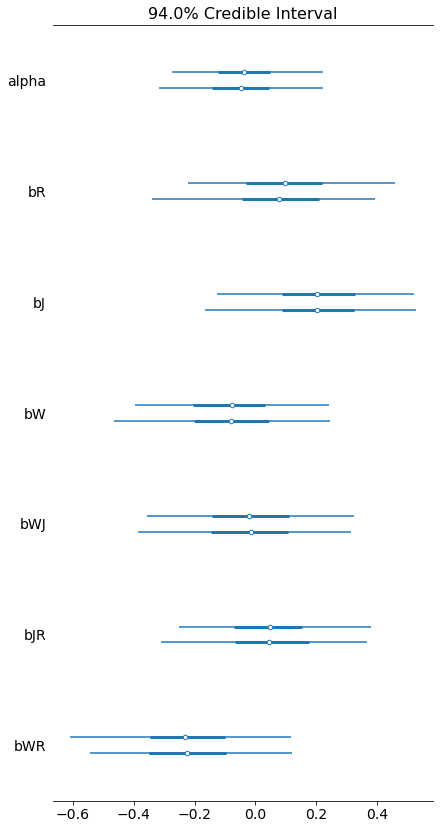

In [13]:
pm.forestplot(int_trace, var_names = ['alpha', 'bR', 'bJ', 'bW', 'bWJ', 'bJR', 'bWR'])

## Visualizing the predictions

Interpreting the parameters, especially the interaction parameters, can be a bit tricky. To clarify this, let's extract samples from the trace to evaluate our predicted scores for each of the combinations of predictors. We can do this by simply plugging the sampled values from the trace into the model equation.

In [14]:
RAA = int_trace['bR'] + int_trace['bJ'] + int_trace['bW'] + \
      int_trace['bWJ'] + int_trace['bJR'] + int_trace['bWR'] + int_trace['alpha']
WAA = int_trace['bJ'] + int_trace['bW'] + int_trace['bWJ'] + int_trace['alpha']
RFA = int_trace['bR'] + int_trace['bW'] + int_trace['bWR'] + int_trace['alpha']
WFA = int_trace['bW'] + int_trace['alpha']
RAF = int_trace['bR'] + int_trace['bJ'] + int_trace['bJR'] + int_trace['alpha']
WAF = int_trace['bJ'] + int_trace['alpha']
RFF = int_trace['bR'] + int_trace['alpha']
WFF = int_trace['alpha']

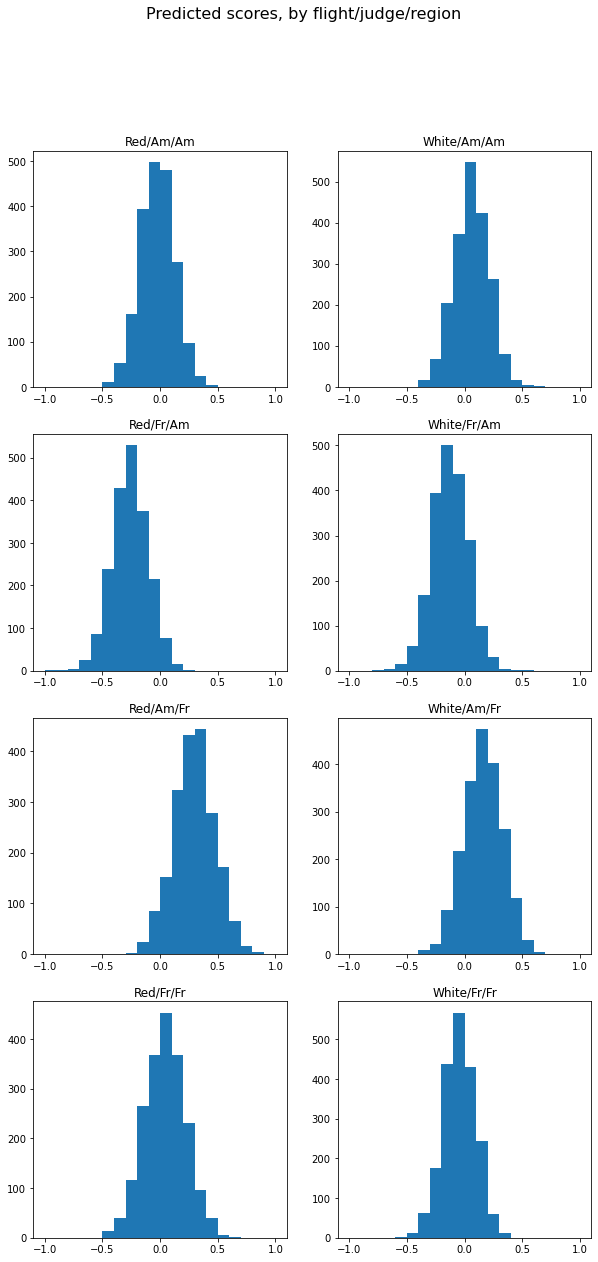

In [15]:
fig, axs = plt.subplots(4,2, figsize = (10, 20))
fig.suptitle('Predicted scores, by flight/judge/region', size = 16)
axs[0,0].hist(RAA, bins = np.arange(-1, 1.1, 0.1))
axs[0,0].set_title('Red/Am/Am')
axs[1,0].hist(RFA, bins = np.arange(-1, 1.1, 0.1))
axs[1,0].set_title('Red/Fr/Am')
axs[2,0].hist(RAF, bins = np.arange(-1, 1.1, 0.1))
axs[2,0].set_title('Red/Am/Fr')
axs[3,0].hist(RFF, bins = np.arange(-1, 1.1, 0.1))
axs[3,0].set_title('Red/Fr/Fr')
axs[0,1].hist(WAA, bins = np.arange(-1, 1.1, 0.1))
axs[0,1].set_title('White/Am/Am')
axs[1,1].hist(WFA, bins = np.arange(-1, 1.1, 0.1))
axs[1,1].set_title('White/Fr/Am')
axs[2,1].hist(WAF, bins = np.arange(-1, 1.1, 0.1))
axs[2,1].set_title('White/Am/Fr')
axs[3,1].hist(WFF, bins = np.arange(-1, 1.1, 0.1))
axs[3,1].set_title('White/Fr/Fr')
plt.show()

This clarifies the region/color interaction, which was the only clearly nonzero interaction from the parameter table. Red French wines were rated higher than average by American judges (although only about average by French judges) while red American wines were rated relatively poorly by the French judges. So, being red and American together appears to carry a bit of a disadvantage -- although how this manifests is dependent on the judge.

### Full interaction model

In [16]:
with pm.Model() as interaction:
    bRAA = pm.Normal('bRAA', 0, 0.5)
    bWAA = pm.Normal('bWAA', 0, 0.5)
    bRFA = pm.Normal('bRFA', 0, 0.5)
    bWFA = pm.Normal('bWFA', 0, 0.5)
    bRAF = pm.Normal('bRAF', 0, 0.5)
    bWAF = pm.Normal('bWAF', 0, 0.5)
    bRFF = pm.Normal('bRFF', 0, 0.5)
    bWFF = pm.Normal('bWFF', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', 0, 0.2)
    mu = alpha + bRAA * wines['flight'] * wines['judge.amer'] * wines['wine.amer'] + \
                 bWAA * (1-wines['flight']) * wines['judge.amer'] * wines['wine.amer'] + \
                 bRFA * wines['flight'] * (1-wines['judge.amer']) * wines['wine.amer'] + \
                 bWFA * (1-wines['flight']) * (1-wines['judge.amer']) * wines['wine.amer'] + \
                 bRAF * wines['flight'] * wines['judge.amer'] * (1-wines['wine.amer']) + \
                 bWAF * (1-wines['flight']) * wines['judge.amer'] * (1-wines['wine.amer']) + \
                 bRFF * wines['flight'] * (1-wines['judge.amer']) * (1-wines['wine.amer']) + \
                 bWFF * (1-wines['flight']) * (1-wines['judge.amer']) * (1-wines['wine.amer'])  
    score = pm.Normal('score', mu=mu, sigma=sigma, observed=wines['score'])
    
    fullint_trace = pm.sample(1000, target_accept = 0.9)
    fullint_sumtab = pm.summary(fullint_trace, var_names = ['alpha', 'bRAA', 'bWAA', 'bRFA', 'bWFA', 'bRAF', 'bWAF', 'bRFF', 'bWFF'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sigma, bWFF, bRFF, bWAF, bRAF, bWFA, bRFA, bWAA, bRAA]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:03<00:00, 838.19draws/s]


In [17]:
fullint_sumtab

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.001,0.136,-0.258,0.245,0.005,0.004,684.0,684.0,680.0,1286.0,1.0
bRAA,-0.011,0.199,-0.359,0.399,0.006,0.004,1204.0,1204.0,1204.0,1399.0,1.0
bWAA,0.039,0.211,-0.340,0.461,0.006,0.005,1117.0,992.0,1121.0,1154.0,1.0
bRFA,-0.361,0.224,-0.797,0.039,0.006,0.004,1412.0,1368.0,1416.0,1447.0,1.0
bWFA,0.037,0.215,-0.394,0.414,0.006,0.004,1289.0,1194.0,1283.0,1541.0,1.0
bRAF,0.268,0.226,-0.169,0.686,0.006,0.004,1394.0,1309.0,1391.0,1496.0,1.0
bWAF,0.170,0.234,-0.264,0.583,0.007,0.005,1286.0,1206.0,1271.0,1378.0,1.0
bRFF,0.202,0.248,-0.265,0.657,0.007,0.005,1373.0,1302.0,1375.0,1507.0,1.0
bWFF,-0.303,0.245,-0.759,0.151,0.006,0.004,1640.0,1488.0,1642.0,1448.0,1.0


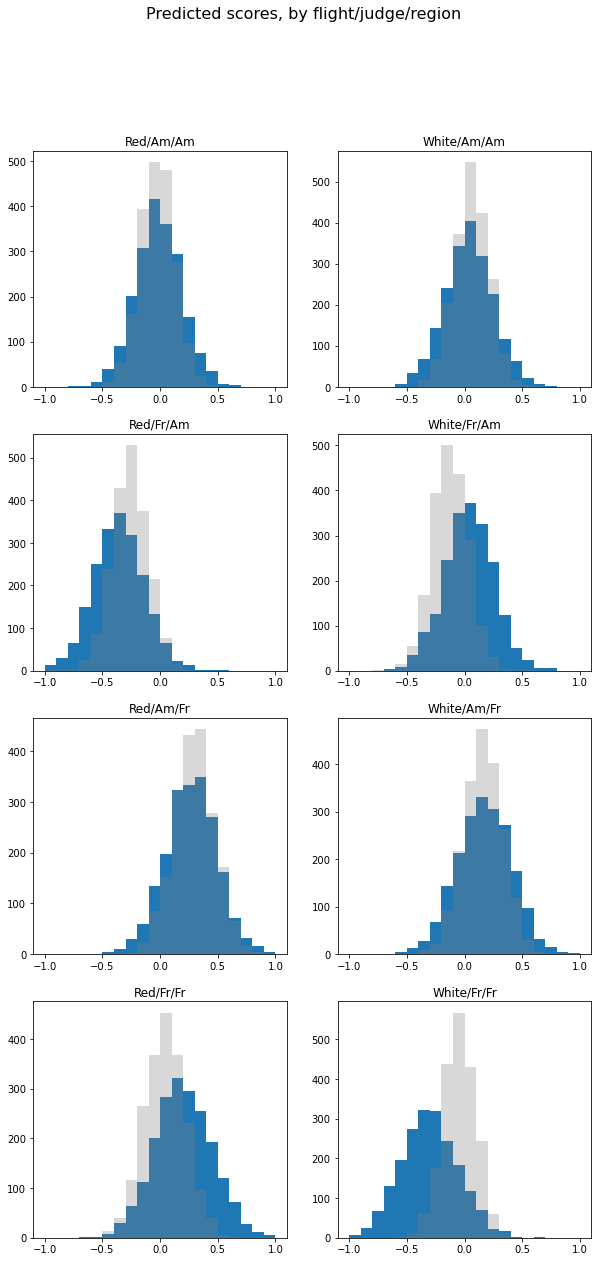

In [18]:
fig, axs = plt.subplots(4,2, figsize = (10, 20))
fig.suptitle('Predicted scores, by flight/judge/region', size = 16)
axs[0,0].hist(fullint_trace['bRAA'], bins = np.arange(-1, 1.1, 0.1))
axs[0,0].set_title('Red/Am/Am')
axs[1,0].hist(fullint_trace['bRFA'], bins = np.arange(-1, 1.1, 0.1))
axs[1,0].set_title('Red/Fr/Am')
axs[2,0].hist(fullint_trace['bRAF'], bins = np.arange(-1, 1.1, 0.1))
axs[2,0].set_title('Red/Am/Fr')
axs[3,0].hist(fullint_trace['bRFF'], bins = np.arange(-1, 1.1, 0.1))
axs[3,0].set_title('Red/Fr/Fr')
axs[0,1].hist(fullint_trace['bWAA'], bins = np.arange(-1, 1.1, 0.1))
axs[0,1].set_title('White/Am/Am')
axs[1,1].hist(fullint_trace['bWFA'], bins = np.arange(-1, 1.1, 0.1))
axs[1,1].set_title('White/Fr/Am')
axs[2,1].hist(fullint_trace['bWAF'], bins = np.arange(-1, 1.1, 0.1))
axs[2,1].set_title('White/Am/Fr')
axs[3,1].hist(fullint_trace['bWFF'], bins = np.arange(-1, 1.1, 0.1))
axs[3,1].set_title('White/Fr/Fr')

axs[0,0].hist(RAA, bins = np.arange(-1, 1.1, 0.1), color = 'gray', alpha = 0.3)
axs[1,0].hist(RFA, bins = np.arange(-1, 1.1, 0.1), color = 'gray', alpha = 0.3)
axs[2,0].hist(RAF, bins = np.arange(-1, 1.1, 0.1), color = 'gray', alpha = 0.3)
axs[3,0].hist(RFF, bins = np.arange(-1, 1.1, 0.1), color = 'gray', alpha = 0.3)
axs[0,1].hist(WAA, bins = np.arange(-1, 1.1, 0.1), color = 'gray', alpha = 0.3)
axs[1,1].hist(WFA, bins = np.arange(-1, 1.1, 0.1), color = 'gray', alpha = 0.3)
axs[2,1].hist(WAF, bins = np.arange(-1, 1.1, 0.1), color = 'gray', alpha = 0.3)
axs[3,1].hist(WFF, bins = np.arange(-1, 1.1, 0.1), color = 'gray', alpha = 0.3)

plt.show()

The biggest difference is that the White/French/French predicted score is lower in this model. Why? The previous model has less flexibility. 
In the previous model, White/French/French corresponds to all the indicator variables being zero, so we just have
$$ \hat y = \alpha $$
and since our outcomes are standardized, we should generally have $\alpha = 0$. This has, in a way, positioned White/French/French artificially as a "default", with all wines measured relative to it.

In this model, every combination of traits gets its own parameter, and so they can vary freely.